Decidimos eliminar los nodos de casos de rabia y ponerlos como atributos en las cuadras como distancias. También se va a generar 2 grafos, uno para 2025-2022 y otro 2023-2024

In [ ]:
pip install pyreadr pandas torch fastkml torch_geometric folium geopandas optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Load Graph

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!ls "./drive/MyDrive/Colab Notebooks/dataset/"

rf_cuadras.gpkg		   zamacola_heterograph_fase2_1.pt
zamacola_heterograph_2.pt  zamacola_heterograph_fase2.pt
zamacola_heterograph_3.pt  zamacola_heterograph.pt
zamacola_heterograph_4.pt


In [ ]:
import torch

# Cargar el grafo
data = torch.load("./drive/MyDrive/Colab Notebooks/dataset/zamacola_heterograph_fase2.pt", weights_only=False)

print("✅ Grafo heterogéneo cargado correctamente")
print(data)

✅ Grafo heterogéneo cargado correctamente
HeteroData(
  cuadra={
    x=[4296, 8],
    feature_columns=[8],
    cuadra_id=[4296],
    node_index=[4296],
    y=[4296],
  },
  health_post={
    x=[4, 2],
    name=[4],
    node_index=[4],
  },
  water_channel={
    x=[218, 2],
    ident=[218],
    node_index=[218],
  },
  (cuadra, vecina_de, cuadra)={ edge_index=[2, 64086] },
  (cuadra, reporta_a, health_post)={
    edge_index=[2, 4296],
    edge_attr=[4296, 1],
  },
  (health_post, atiende_a, cuadra)={
    edge_index=[2, 4296],
    edge_attr=[4296, 1],
  },
  (cuadra, cerca_de, water_channel)={
    edge_index=[2, 9228],
    edge_attr=[9228, 1],
  }
)


In [ ]:
# ============================
# 1. INSTALAR DEPENDENCIAS EN COLAB
# ============================
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install geopandas scikit-learn networkx matplotlib tqdm

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# ============================
# - IMPORTAR LIBRERIAS
# ============================
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv, Linear
from torch_geometric.data import HeteroData
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import classification_report
import random

In [ ]:
# ============================
# - CREAR ETIQUETAS BINARIAS + RIESGO VECINAL (CLASIFICACION BINARIA)
# ============================
# - VERIFICACIÓN DE ETIQUETAS venidas del grafo

cuadra_labels = data['cuadra'].y  # Ya están en el grafo

print(f"Etiquetas positivas: {(cuadra_labels == 1).sum().item()} / {cuadra_labels.numel()}")


Etiquetas positivas: 75 / 4296


In [ ]:
# ============================
# - SPLIT DE DATOS (train / val) 80/20
# ============================

# Se obtiene el total de nodos (cuadras) y sus etiquetas (y, previamente construidas).
nodos = torch.arange(data['cuadra'].num_nodes)
labels = data['cuadra'].y

# Inicializa los vectores de entrenamiento y validación
train_mask = torch.zeros_like(labels, dtype=torch.bool)
val_mask = torch.zeros_like(labels, dtype=torch.bool)

# Índices positivos y negativos
pos = (labels == 1).nonzero(as_tuple=True)[0]
neg = (labels == 0).nonzero(as_tuple=True)[0]

# Mezclar aleatoriamente
random.seed(42)
pos = pos[torch.randperm(len(pos))]
neg = neg[torch.randperm(len(neg))]

# Función para dividir en 80/20
def split_indices(indices):
    n = len(indices)
    n_train = int(0.8 * n)
    n_val = n - n_train
    return indices[:n_train], indices[n_train:]

# Dividir positivos
pos_train, pos_val = split_indices(pos)
# Dividir negativos
neg_train, neg_val = split_indices(neg)

# Combinar train / val / test
train_idx = torch.cat([pos_train, neg_train])
val_idx = torch.cat([pos_val, neg_val])

# Asignar máscaras
train_mask[train_idx] = True
val_mask[val_idx] = True

# Guardar en el objeto `data`
data['cuadra'].train_mask = train_mask
data['cuadra'].val_mask = val_mask

# Contrar la cantidad de positivos y negativos por cada conjunto
def contar_clases(mask, labels):
    positivos = ((labels == 1) & mask).sum().item()
    negativos = ((labels == 0) & mask).sum().item()
    return positivos, negativos

# Contar clases
train_pos, train_neg = contar_clases(train_mask, labels)
val_pos, val_neg = contar_clases(val_mask, labels)

# Imprimir resultados
print(f"Train: {train_pos} positivos, {train_neg} negativos")
print(f"Val:   {val_pos} positivos, {val_neg} negativos")


Train: 60 positivos, 3376 negativos
Val:   15 positivos, 845 negativos


Nuestro modelo prioriza maximizar el Recall para no dejar brotes sin detectar, aunque eso implique más falsos positivos. Sin embargo, buscamos también un buen F1 Score como balance general.

Nodos:
- Cuadra: x= lat, long, ingreso_economico.
- health_post: x =lat, long.
- water_channel: x= lat, long.
- rabies_case: x = lat, long - year = anio

Relaciones
- "cuadra", "vecina_de", "cuadra": Cuadra ↔ Cuadra (vecinas por distancia entre centroides) 100 metros, bidireccional.
- "cuadra", "reporta_a", "health_post": Cuadra → Puesto de salud más cercano y pone la distancia como atributo (NOTA: Estos modelo utilizarian el atributo de la distancia NNConv, GATv2Conv los demas no)
- "health_post", "atiende_a", "cuadra": Es la inversa de reporta_a.
- "cuadra", "cerca_de", "water_channel": Cuadra → Torrenteras (con distancia como atributo).
- "rabies_case", "ocurre_en", "cuadra": Caso de rabia a que Cuadra pertenece y si no da dentro de una cuadra se busca la cuadra mas cercana al punto.
- "cuadra", "tiene_caso", "rabies_case": La inversa de ocurre_en.
- "cuadra", "vecina_con_riesgo", "cuadra": Cuadras vecinas con riesgo (por proximidad a casos) No bidireccional por que no es lo mismo decir que la cuadra B esta con riesgo por ser vecina de una que tiene rabia a decir que la cuadra A esta con riesgo por tener a una cuadra que no esta infectada que seria la cuadra B.

Por que elegimos 100 m:

Hicimos pruebas empíricas con diferentes radios, y 100m ofreció el mejor balance entre precisión del modelo y simplicidad de interpretación sin sacrificar recall, lo cual es importante en el contexto de epidemias.

# OPTUNA

In [ ]:
!pip install optuna

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import optuna
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
import json
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def define_model(hidden_channels, dropout_p):
    class BinaryHeteroGNN(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.dropout = torch.nn.Dropout(dropout_p)
            self.lin_dict = torch.nn.ModuleDict()
            for node_type in data.node_types:
                in_feats = data[node_type].num_node_features
                self.lin_dict[node_type] = torch.nn.Linear(in_feats, hidden_channels)

            self.conv1 = HeteroConv({
                ('cuadra', 'vecina_de', 'cuadra'): SAGEConv(hidden_channels, hidden_channels),
                ('cuadra', 'reporta_a', 'health_post'): SAGEConv(hidden_channels, hidden_channels),
                ('health_post', 'atiende_a', 'cuadra'): SAGEConv(hidden_channels, hidden_channels),
                ('cuadra', 'cerca_de', 'water_channel'): SAGEConv(hidden_channels, hidden_channels),
            }, aggr='sum')

            self.conv2 = HeteroConv({
                ('cuadra', 'vecina_de', 'cuadra'): SAGEConv(hidden_channels, hidden_channels),
                ('cuadra', 'reporta_a', 'health_post'): SAGEConv(hidden_channels, hidden_channels),
                ('health_post', 'atiende_a', 'cuadra'): SAGEConv(hidden_channels, hidden_channels),
                ('cuadra', 'cerca_de', 'water_channel'): SAGEConv(hidden_channels, hidden_channels),
            }, aggr='sum')

            self.classifier = torch.nn.Linear(hidden_channels, 1)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {k: self.lin_dict[k](v) for k, v in x_dict.items()}
            x_dict = self.conv1(x_dict, edge_index_dict)
            x_dict = {k: self.dropout(F.relu(v)) for k, v in x_dict.items()}
            x_dict = self.conv2(x_dict, edge_index_dict)
            return self.classifier(x_dict["cuadra"]).squeeze()

    return BinaryHeteroGNN()

# Crear contenedor para guardar el mejor modelo
best_model_holder = {"model": None}

def objective(trial):
    hidden_channels = trial.suggest_categorical("hidden_channels", [32, 64, 128])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    dropout = trial.suggest_uniform("dropout", 0.3, 0.7)
    weight_clip = trial.suggest_uniform("pos_weight_clip", 5.0, 20.0)

    model = define_model(hidden_channels, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    labels = data['cuadra'].y.to(device)
    train_mask = data['cuadra'].train_mask.to(device)
    val_mask = data['cuadra'].val_mask.to(device)

    num_pos = (labels[train_mask] == 1).sum()
    num_neg = (labels[train_mask] == 0).sum()
    pos_weight = torch.tensor([min(num_neg / num_pos, weight_clip)], dtype=torch.float).to(device)

    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    for epoch in range(1, 101):
        model.train()
        out = model(data.x_dict, data.edge_index_dict)
        loss = criterion(out[train_mask], labels[train_mask].float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validación
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        preds_val = (torch.sigmoid(out[val_mask]) > 0.5).cpu()
        labels_val = labels[val_mask].cpu()
        f1_val = f1_score(labels_val, preds_val, zero_division=0)

        # Almacenando metricas para mostrarlas
        precision_val = precision_score(labels_val, preds_val, zero_division=0)
        recall_val = recall_score(labels_val, preds_val, zero_division=0)
        f1_val = f1_score(labels_val, preds_val, zero_division=0)
        acc_val = accuracy_score(labels_val, preds_val)

    # Guardar métricas como atributos del trial
    trial.set_user_attr("precision", precision_val)
    trial.set_user_attr("recall", recall_val)
    trial.set_user_attr("f1", f1_val)
    trial.set_user_attr("accuracy", acc_val)

    print(f"Trial {trial.number}: F1-score={f1_val:.4f} | Precision={precision_val:.4f} | Recall={recall_val:.4f} | Acc={acc_val:.4f}")

    # Guardar si es el mejor hasta ahora
    completed_trials = [t for t in trial.study.trials if t.value is not None]
    best_f1 = max([t.value for t in completed_trials], default=0)

    if f1_val >= best_f1:
        torch.save(model.state_dict(), "./drive/MyDrive/Colab Notebooks/result/mejor_modelo_fase2.pt")
        with open("./drive/MyDrive/Colab Notebooks/result/mejores_parametros_fase2.json", "w") as f:
            json.dump(trial.params, f)
        best_model_holder["model"] = copy.deepcopy(model)  # guardar modelo entrenado
        print("  ✅ Nuevo mejor modelo guardado")

    return f1_val

# Crear y ejecutar estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Mostrar mejores resultados al final
print("\n🔍 Mejor trial encontrado:")
print(f"Trial #{study.best_trial.number}")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")
print(f"Mejor F1-score en validación: {study.best_value:.4f}")


[I 2025-07-11 03:22:19,560] A new study created in memory with name: no-name-0a0b15d2-9ff5-47cd-819f-b13008873e30
[I 2025-07-11 03:22:23,904] Trial 0 finished with value: 0.0 and parameters: {'hidden_channels': 32, 'lr': 0.0002517810742809842, 'dropout': 0.5692863695970647, 'pos_weight_clip': 10.612330631723884}. Best is trial 0 with value: 0.0.


Trial 0: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826
  ✅ Nuevo mejor modelo guardado


[I 2025-07-11 03:22:33,714] Trial 1 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.0007253337089269161, 'dropout': 0.3485808134082904, 'pos_weight_clip': 9.61989867634481}. Best is trial 0 with value: 0.0.


Trial 1: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826
  ✅ Nuevo mejor modelo guardado


[I 2025-07-11 03:22:42,112] Trial 2 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.003016493017543485, 'dropout': 0.40598449326487057, 'pos_weight_clip': 17.10276353645599}. Best is trial 0 with value: 0.0.


Trial 2: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826
  ✅ Nuevo mejor modelo guardado


[I 2025-07-11 03:22:59,058] Trial 3 finished with value: 0.25925925925925924 and parameters: {'hidden_channels': 128, 'lr': 0.0005137929479893762, 'dropout': 0.3127767083429048, 'pos_weight_clip': 17.987190905332998}. Best is trial 3 with value: 0.25925925925925924.


Trial 3: F1-score=0.2593 | Precision=0.1505 | Recall=0.9333 | Acc=0.9070
  ✅ Nuevo mejor modelo guardado


[I 2025-07-11 03:23:02,866] Trial 4 finished with value: 0.0 and parameters: {'hidden_channels': 32, 'lr': 0.0002572123340207518, 'dropout': 0.6798665765297353, 'pos_weight_clip': 18.77072056540083}. Best is trial 3 with value: 0.25925925925925924.


Trial 4: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:23:20,323] Trial 5 finished with value: 0.9655172413793104 and parameters: {'hidden_channels': 128, 'lr': 0.0025078505850294813, 'dropout': 0.5298444030151633, 'pos_weight_clip': 13.788448659519439}. Best is trial 5 with value: 0.9655172413793104.


Trial 5: F1-score=0.9655 | Precision=1.0000 | Recall=0.9333 | Acc=0.9988
  ✅ Nuevo mejor modelo guardado


[I 2025-07-11 03:23:39,399] Trial 6 finished with value: 0.23529411764705882 and parameters: {'hidden_channels': 128, 'lr': 0.0037734052730737937, 'dropout': 0.6725241848663805, 'pos_weight_clip': 11.666154422133303}. Best is trial 5 with value: 0.9655172413793104.


Trial 6: F1-score=0.2353 | Precision=1.0000 | Recall=0.1333 | Acc=0.9849


[I 2025-07-11 03:23:59,964] Trial 7 finished with value: 0.0 and parameters: {'hidden_channels': 128, 'lr': 0.001966615509777495, 'dropout': 0.5656654777825054, 'pos_weight_clip': 7.242964539052608}. Best is trial 5 with value: 0.9655172413793104.


Trial 7: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:24:07,813] Trial 8 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.002193559107412886, 'dropout': 0.46649517003302443, 'pos_weight_clip': 8.1064358602324}. Best is trial 5 with value: 0.9655172413793104.


Trial 8: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:24:14,595] Trial 9 finished with value: 0.75 and parameters: {'hidden_channels': 64, 'lr': 0.001060214656152778, 'dropout': 0.3807265713834477, 'pos_weight_clip': 14.832571355409245}. Best is trial 5 with value: 0.9655172413793104.


Trial 9: F1-score=0.7500 | Precision=1.0000 | Recall=0.6000 | Acc=0.9930


[I 2025-07-11 03:24:33,004] Trial 10 finished with value: 0.0 and parameters: {'hidden_channels': 128, 'lr': 0.009598308108186227, 'dropout': 0.5324019663645345, 'pos_weight_clip': 13.920333934005004}. Best is trial 5 with value: 0.9655172413793104.


Trial 10: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:24:39,831] Trial 11 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.0012045986406004677, 'dropout': 0.45862249620855616, 'pos_weight_clip': 14.803549962364775}. Best is trial 5 with value: 0.9655172413793104.


Trial 11: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:24:57,004] Trial 12 finished with value: 0.0 and parameters: {'hidden_channels': 128, 'lr': 0.0001119596715564752, 'dropout': 0.3972947320382739, 'pos_weight_clip': 14.87391909354509}. Best is trial 5 with value: 0.9655172413793104.


Trial 12: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:25:06,299] Trial 13 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.0061511281160125135, 'dropout': 0.5947471905331441, 'pos_weight_clip': 5.181697814028523}. Best is trial 5 with value: 0.9655172413793104.


Trial 13: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:25:10,040] Trial 14 finished with value: 0.125 and parameters: {'hidden_channels': 32, 'lr': 0.001203833766321515, 'dropout': 0.4998301450027681, 'pos_weight_clip': 13.184207521075768}. Best is trial 5 with value: 0.9655172413793104.


Trial 14: F1-score=0.1250 | Precision=1.0000 | Recall=0.0667 | Acc=0.9837


[I 2025-07-11 03:25:27,731] Trial 15 finished with value: 0.0 and parameters: {'hidden_channels': 128, 'lr': 0.000707216348287868, 'dropout': 0.4107750685265452, 'pos_weight_clip': 16.27929111774031}. Best is trial 5 with value: 0.9655172413793104.


Trial 15: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:25:35,005] Trial 16 finished with value: 0.8 and parameters: {'hidden_channels': 64, 'lr': 0.0017131433894121888, 'dropout': 0.6140517231437865, 'pos_weight_clip': 11.859724672536998}. Best is trial 5 with value: 0.9655172413793104.


Trial 16: F1-score=0.8000 | Precision=1.0000 | Recall=0.6667 | Acc=0.9942


[I 2025-07-11 03:25:53,253] Trial 17 finished with value: 0.0 and parameters: {'hidden_channels': 128, 'lr': 0.005048852450027213, 'dropout': 0.6114060194029984, 'pos_weight_clip': 12.325036624889336}. Best is trial 5 with value: 0.9655172413793104.


Trial 17: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:26:01,129] Trial 18 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.002575081358106966, 'dropout': 0.6337831881726881, 'pos_weight_clip': 19.861464575375614}. Best is trial 5 with value: 0.9655172413793104.


Trial 18: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:26:04,880] Trial 19 finished with value: 0.0 and parameters: {'hidden_channels': 32, 'lr': 0.0016944553048878486, 'dropout': 0.5235677506142368, 'pos_weight_clip': 9.9995621462605}. Best is trial 5 with value: 0.9655172413793104.


Trial 19: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:26:21,745] Trial 20 finished with value: 0.0 and parameters: {'hidden_channels': 128, 'lr': 0.00040695226507978844, 'dropout': 0.6329752221153071, 'pos_weight_clip': 8.132373892536384}. Best is trial 5 with value: 0.9655172413793104.


Trial 20: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9733


[I 2025-07-11 03:26:29,593] Trial 21 finished with value: 0.9655172413793104 and parameters: {'hidden_channels': 64, 'lr': 0.0014679316433196166, 'dropout': 0.45337971494503526, 'pos_weight_clip': 16.03320966899146}. Best is trial 5 with value: 0.9655172413793104.


Trial 21: F1-score=0.9655 | Precision=1.0000 | Recall=0.9333 | Acc=0.9988
  ✅ Nuevo mejor modelo guardado


[I 2025-07-11 03:26:36,565] Trial 22 finished with value: 0.9655172413793104 and parameters: {'hidden_channels': 64, 'lr': 0.0016464567120922254, 'dropout': 0.46395959734058967, 'pos_weight_clip': 16.385507541540523}. Best is trial 5 with value: 0.9655172413793104.


Trial 22: F1-score=0.9655 | Precision=1.0000 | Recall=0.9333 | Acc=0.9988
  ✅ Nuevo mejor modelo guardado


[I 2025-07-11 03:26:44,301] Trial 23 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.003550764499388649, 'dropout': 0.45163549665204306, 'pos_weight_clip': 16.33397373734888}. Best is trial 5 with value: 0.9655172413793104.


Trial 23: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:26:51,403] Trial 24 finished with value: 0.125 and parameters: {'hidden_channels': 64, 'lr': 0.0015445993154781152, 'dropout': 0.4883570691950258, 'pos_weight_clip': 16.514726151003813}. Best is trial 5 with value: 0.9655172413793104.


Trial 24: F1-score=0.1250 | Precision=1.0000 | Recall=0.0667 | Acc=0.9837


[I 2025-07-11 03:26:59,068] Trial 25 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.0007942881982850099, 'dropout': 0.5269421914718049, 'pos_weight_clip': 15.505881299971108}. Best is trial 5 with value: 0.9655172413793104.


Trial 25: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:27:07,385] Trial 26 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.006826374552818409, 'dropout': 0.43654478506978667, 'pos_weight_clip': 13.596884067444583}. Best is trial 5 with value: 0.9655172413793104.


Trial 26: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:27:14,523] Trial 27 finished with value: 0.0 and parameters: {'hidden_channels': 64, 'lr': 0.004071506384655067, 'dropout': 0.43062852892047726, 'pos_weight_clip': 18.040194600638767}. Best is trial 5 with value: 0.9655172413793104.


Trial 27: F1-score=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


[I 2025-07-11 03:27:18,243] Trial 28 finished with value: 0.9032258064516129 and parameters: {'hidden_channels': 32, 'lr': 0.002791551977326023, 'dropout': 0.482693827370196, 'pos_weight_clip': 19.374753341852447}. Best is trial 5 with value: 0.9655172413793104.


Trial 28: F1-score=0.9032 | Precision=0.8750 | Recall=0.9333 | Acc=0.9965


[I 2025-07-11 03:27:36,261] Trial 29 finished with value: 0.23529411764705882 and parameters: {'hidden_channels': 128, 'lr': 0.0005144792698690014, 'dropout': 0.5539249049669053, 'pos_weight_clip': 17.33692237219446}. Best is trial 5 with value: 0.9655172413793104.


Trial 29: F1-score=0.2353 | Precision=1.0000 | Recall=0.1333 | Acc=0.9849

🔍 Mejor trial encontrado:
Trial #5
  hidden_channels: 128
  lr: 0.0025078505850294813
  dropout: 0.5298444030151633
  pos_weight_clip: 13.788448659519439
Mejor F1-score en validación: 0.9655



📋 Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       1.00      1.00      1.00       845
    Positivo       1.00      0.93      0.97        15

    accuracy                           1.00       860
   macro avg       1.00      0.97      0.98       860
weighted avg       1.00      1.00      1.00       860


🔢 Métricas individuales:
Precisión: 1.0000
Recall: 0.9333
F1-score: 0.9655
Accuracy: 0.9988


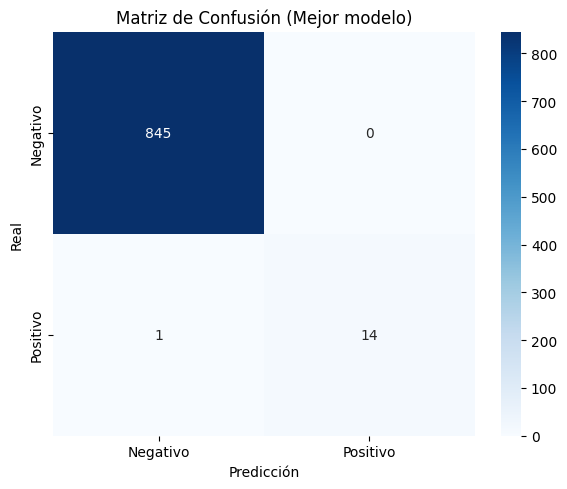

In [ ]:
# ----------------------------
# CARGAR EL MEJOR MODELO
# ----------------------------

import torch
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 0: Cargar el modelo
#with open("mejores_parametros.json", "r") as f:
#    params = json.load(f)

#model = BinaryHeteroGNN(**params).to(device)
#model.load_state_dict(torch.load("mejor_modelo.pt"))

# Paso 1: Reconstruir el modelo y cargar el mejor estado guardado
best_model = best_model_holder["model"]
best_model.eval()

# Paso 2: Forward del mejor modelo
with torch.no_grad():
    out = best_model(data.x_dict, data.edge_index_dict)
    preds = (torch.sigmoid(out[val_mask]) > 0.5).cpu().numpy()
    true_labels = labels[val_mask].cpu().numpy()

# Paso 3: Reporte de clasificación
print("\n📋 Reporte de clasificación:")
print(classification_report(true_labels, preds, target_names=["Negativo", "Positivo"]))

# Paso 4: Métricas individuales
precision_val = precision_score(true_labels, preds, zero_division=0)
recall_val = recall_score(true_labels, preds, zero_division=0)
f1_val = f1_score(true_labels, preds, zero_division=0)
accuracy_val = (preds == true_labels).mean()

print(f"\n🔢 Métricas individuales:")
print(f"Precisión: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-score: {f1_val:.4f}")
print(f"Accuracy: {accuracy_val:.4f}")

# Paso 5: Matriz de confusión
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negativo", "Positivo"],
            yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Mejor modelo)")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


# Datos TEST

In [ ]:
import torch

# Cargar el grafo
data_test = torch.load("./drive/MyDrive/Colab Notebooks/dataset/test_zamacola_heterograph_fase2.pt", weights_only=False)

print("✅ Grafo heterogéneo cargado correctamente")
print(data_test)

✅ Grafo heterogéneo cargado correctamente
HeteroData(
  cuadra={
    x=[4296, 8],
    feature_columns=[8],
    cuadra_id=[4296],
    node_index=[4296],
    y=[4296],
  },
  health_post={
    x=[4, 2],
    name=[4],
    node_index=[4],
  },
  water_channel={
    x=[218, 2],
    ident=[218],
    node_index=[218],
  },
  (cuadra, vecina_de, cuadra)={ edge_index=[2, 64086] },
  (cuadra, reporta_a, health_post)={
    edge_index=[2, 4296],
    edge_attr=[4296, 1],
  },
  (health_post, atiende_a, cuadra)={
    edge_index=[2, 4296],
    edge_attr=[4296, 1],
  },
  (cuadra, cerca_de, water_channel)={
    edge_index=[2, 9228],
    edge_attr=[9228, 1],
  }
)


In [ ]:
# ============================
# - CREAR ETIQUETAS BINARIAS + RIESGO VECINAL (CLASIFICACION BINARIA)
# ============================
# - VERIFICACIÓN DE ETIQUETAS venidas del grafo

cuadra_labels_test = data_test['cuadra'].y  # Ya están en el grafo

print(f"Etiquetas positivas: {(cuadra_labels_test == 1).sum().item()} / {cuadra_labels_test.numel()}")

Etiquetas positivas: 13 / 4296


In [ ]:
# Evaluación del mejor modelo sobre el grafo de test
best_model.eval()
data_test = data_test.to(device)
best_model = best_model.to(device)

with torch.no_grad():
    out_test = best_model(data_test.x_dict, data_test.edge_index_dict)
    pred_probs_test = torch.sigmoid(out_test)
    pred_labels_test = (pred_probs_test > 0.5).long()

true_labels_test = data_test["cuadra"].y.cpu().numpy()
pred_labels_test_np = pred_labels_test.cpu().numpy()

from sklearn.metrics import classification_report
print(classification_report(true_labels_test, pred_labels_test_np, digits=4))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4283
           1     1.0000    1.0000    1.0000        13

    accuracy                         1.0000      4296
   macro avg     1.0000    1.0000    1.0000      4296
weighted avg     1.0000    1.0000    1.0000      4296



# RANDOM FOREST

In [ ]:
import geopandas as gpd
rf_cuadras = gpd.read_file('./drive/MyDrive/Colab Notebooks/dataset/rf_cuadras.gpkg')
rf_cuadras.head()

,cuadra_id,ingreso_B,ingreso_C,ingreso_D,ingreso_E,num_rabies_cases_in_cuadra,dist_to_nearest_health_post,dist_to_nearest_water_channel,min_dist_to_rabies_case,y,geometry
0,1.4.100-1,False,False,True,False,0,1815.732788,9999.000000,9999.000000,0,"POLYGON ((224268.545 8190480.422, 224175.196 8..."
1,1.4.100-10,False,False,True,False,0,1610.846277,415.993967,9999.000000,0,"POLYGON ((223983.171 8191303.516, 223985.935 8..."
2,1.4.100-11,False,False,True,False,0,1787.481405,476.290826,32.510141,0,"POLYGON ((223991.362 8191312.242, 224167.947 8..."
3,1.4.100-12,False,False,True,False,0,1521.736024,339.202959,9999.000000,0,"POLYGON ((223736.505 8191347.126, 223726.379 8..."
4,1.4.100-2,False,False,True,False,0,1778.237966,9999.000000,9999.000000,0,"POLYGON ((223940.104 8190652.198, 223924.309 8..."


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import optuna

# Suponiendo que tu DataFrame se llama df
X = rf_cuadras[['ingreso_B', 'ingreso_C', 'ingreso_D', 'ingreso_E', 'dist_to_nearest_health_post', 'dist_to_nearest_water_channel', 'min_dist_to_rabies_case']]
y = rf_cuadras['y']

# Dividir datos 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    f1 = f1_score(y_val, y_pred, zero_division=0)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)

    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("accuracy", acc)

    print(f"Trial {trial.number}: F1={f1:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | Acc={acc:.4f}")

    return f1

study = optuna.create_study(direction="maximize")
study.optimize(rf_objective, n_trials=30)

# Mostrar resultados
print("\n🔍 Mejor trial Random Forest:")
print(f"Trial #{study.best_trial.number}")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")
print(f"Mejor F1-score en validación: {study.best_value:.4f}")

[I 2025-07-11 01:36:18,538] A new study created in memory with name: no-name-6bf7150c-5388-4fd4-b7e7-50f53016afc4
[I 2025-07-11 01:36:19,582] Trial 0 finished with value: 0.41935483870967744 and parameters: {'n_estimators': 114, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.41935483870967744.


Trial 0: F1=0.4194 | Precision=0.2766 | Recall=0.8667 | Acc=0.9581


[I 2025-07-11 01:36:20,412] Trial 1 finished with value: 0.3561643835616438 and parameters: {'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.41935483870967744.


Trial 1: F1=0.3562 | Precision=0.2241 | Recall=0.8667 | Acc=0.9453


[I 2025-07-11 01:36:22,972] Trial 2 finished with value: 0.4230769230769231 and parameters: {'n_estimators': 279, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.4230769230769231.


Trial 2: F1=0.4231 | Precision=0.2973 | Recall=0.7333 | Acc=0.9651


[I 2025-07-11 01:36:23,772] Trial 3 finished with value: 0.4126984126984127 and parameters: {'n_estimators': 116, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.4230769230769231.


Trial 3: F1=0.4127 | Precision=0.2708 | Recall=0.8667 | Acc=0.9570


[I 2025-07-11 01:36:25,399] Trial 4 finished with value: 0.37681159420289856 and parameters: {'n_estimators': 263, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.4230769230769231.


Trial 4: F1=0.3768 | Precision=0.2407 | Recall=0.8667 | Acc=0.9500


[I 2025-07-11 01:36:25,766] Trial 5 finished with value: 0.3466666666666667 and parameters: {'n_estimators': 56, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.4230769230769231.


Trial 5: F1=0.3467 | Precision=0.2167 | Recall=0.8667 | Acc=0.9430


[I 2025-07-11 01:36:27,624] Trial 6 finished with value: 0.3728813559322034 and parameters: {'n_estimators': 235, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.4230769230769231.


Trial 6: F1=0.3729 | Precision=0.2500 | Recall=0.7333 | Acc=0.9570


[I 2025-07-11 01:36:29,442] Trial 7 finished with value: 0.3389830508474576 and parameters: {'n_estimators': 282, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.4230769230769231.


Trial 7: F1=0.3390 | Precision=0.2273 | Recall=0.6667 | Acc=0.9547


[I 2025-07-11 01:36:30,293] Trial 8 finished with value: 0.41935483870967744 and parameters: {'n_estimators': 109, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.4230769230769231.


Trial 8: F1=0.4194 | Precision=0.2766 | Recall=0.8667 | Acc=0.9581


[I 2025-07-11 01:36:30,814] Trial 9 finished with value: 0.3902439024390244 and parameters: {'n_estimators': 61, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.4230769230769231.


Trial 9: F1=0.3902 | Precision=0.3077 | Recall=0.5333 | Acc=0.9709


[I 2025-07-11 01:36:32,361] Trial 10 finished with value: 0.43137254901960786 and parameters: {'n_estimators': 204, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.43137254901960786.


Trial 10: F1=0.4314 | Precision=0.3056 | Recall=0.7333 | Acc=0.9663


[I 2025-07-11 01:36:34,595] Trial 11 finished with value: 0.4230769230769231 and parameters: {'n_estimators': 195, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.43137254901960786.


Trial 11: F1=0.4231 | Precision=0.2973 | Recall=0.7333 | Acc=0.9651


[I 2025-07-11 01:36:37,385] Trial 12 finished with value: 0.4230769230769231 and parameters: {'n_estimators': 197, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.43137254901960786.


Trial 12: F1=0.4231 | Precision=0.2973 | Recall=0.7333 | Acc=0.9651


[I 2025-07-11 01:36:39,357] Trial 13 finished with value: 0.38596491228070173 and parameters: {'n_estimators': 234, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 10 with value: 0.43137254901960786.


Trial 13: F1=0.3860 | Precision=0.2619 | Recall=0.7333 | Acc=0.9593


[I 2025-07-11 01:36:40,568] Trial 14 finished with value: 0.3902439024390244 and parameters: {'n_estimators': 159, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.43137254901960786.


Trial 14: F1=0.3902 | Precision=0.3077 | Recall=0.5333 | Acc=0.9709


[I 2025-07-11 01:36:42,354] Trial 15 finished with value: 0.38596491228070173 and parameters: {'n_estimators': 296, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.43137254901960786.


Trial 15: F1=0.3860 | Precision=0.2619 | Recall=0.7333 | Acc=0.9593


[I 2025-07-11 01:36:43,861] Trial 16 finished with value: 0.391304347826087 and parameters: {'n_estimators': 237, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.43137254901960786.


Trial 16: F1=0.3913 | Precision=0.2903 | Recall=0.6000 | Acc=0.9674


[I 2025-07-11 01:36:44,845] Trial 17 finished with value: 0.3888888888888889 and parameters: {'n_estimators': 161, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.43137254901960786.


Trial 17: F1=0.3889 | Precision=0.3333 | Recall=0.4667 | Acc=0.9744


[I 2025-07-11 01:36:46,912] Trial 18 finished with value: 0.38596491228070173 and parameters: {'n_estimators': 265, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.43137254901960786.


Trial 18: F1=0.3860 | Precision=0.2619 | Recall=0.7333 | Acc=0.9593


[I 2025-07-11 01:36:48,379] Trial 19 finished with value: 0.4 and parameters: {'n_estimators': 202, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.43137254901960786.


Trial 19: F1=0.4000 | Precision=0.3200 | Recall=0.5333 | Acc=0.9721


[I 2025-07-11 01:36:50,929] Trial 20 finished with value: 0.38596491228070173 and parameters: {'n_estimators': 259, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.43137254901960786.


Trial 20: F1=0.3860 | Precision=0.2619 | Recall=0.7333 | Acc=0.9593


[I 2025-07-11 01:36:52,010] Trial 21 finished with value: 0.4230769230769231 and parameters: {'n_estimators': 195, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.43137254901960786.


Trial 21: F1=0.4231 | Precision=0.2973 | Recall=0.7333 | Acc=0.9651


[I 2025-07-11 01:36:52,706] Trial 22 finished with value: 0.4 and parameters: {'n_estimators': 172, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.43137254901960786.


Trial 22: F1=0.4000 | Precision=0.2750 | Recall=0.7333 | Acc=0.9616


[I 2025-07-11 01:36:53,470] Trial 23 finished with value: 0.3888888888888889 and parameters: {'n_estimators': 215, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.43137254901960786.


Trial 23: F1=0.3889 | Precision=0.3333 | Recall=0.4667 | Acc=0.9744


[I 2025-07-11 01:36:53,974] Trial 24 finished with value: 0.38596491228070173 and parameters: {'n_estimators': 136, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 10 with value: 0.43137254901960786.


Trial 24: F1=0.3860 | Precision=0.2619 | Recall=0.7333 | Acc=0.9593


[I 2025-07-11 01:36:54,730] Trial 25 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 216, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.43137254901960786.


Trial 25: F1=0.4286 | Precision=0.3333 | Recall=0.6000 | Acc=0.9721


[I 2025-07-11 01:36:55,536] Trial 26 finished with value: 0.5217391304347826 and parameters: {'n_estimators': 219, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5217391304347826.


Trial 26: F1=0.5217 | Precision=0.7500 | Recall=0.4000 | Acc=0.9872


[I 2025-07-11 01:36:56,377] Trial 27 finished with value: 0.5217391304347826 and parameters: {'n_estimators': 227, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5217391304347826.


Trial 27: F1=0.5217 | Precision=0.7500 | Recall=0.4000 | Acc=0.9872


[I 2025-07-11 01:36:57,273] Trial 28 finished with value: 0.2222222222222222 and parameters: {'n_estimators': 244, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.5217391304347826.


Trial 28: F1=0.2222 | Precision=0.6667 | Recall=0.1333 | Acc=0.9837


[I 2025-07-11 01:36:58,063] Trial 29 finished with value: 0.5217391304347826 and parameters: {'n_estimators': 217, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.5217391304347826.


Trial 29: F1=0.5217 | Precision=0.7500 | Recall=0.4000 | Acc=0.9872

🔍 Mejor trial Random Forest:
Trial #26
  n_estimators: 219
  max_depth: 18
  min_samples_split: 3
  min_samples_leaf: 2
Mejor F1-score en validación: 0.5217


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Escalar características (importante para SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y validación con estratificación
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

def svm_objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e2)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    clf = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        class_weight='balanced',  # para manejar desbalanceo
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    f1 = f1_score(y_val, y_pred, zero_division=0)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)

    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("accuracy", acc)

    print(f"Trial {trial.number}: F1={f1:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | Acc={acc:.4f}")

    return f1

# Crear y ejecutar el estudio
svm_study = optuna.create_study(direction="maximize")
svm_study.optimize(svm_objective, n_trials=30)

# Mostrar mejores resultados
print("\n🔍 Mejor trial SVM:")
print(f"Trial #{svm_study.best_trial.number}")
for k, v in svm_study.best_trial.params.items():
    print(f"  {k}: {v}")
print(f"Mejor F1-score en validación: {svm_study.best_value:.4f}")


[I 2025-07-11 08:43:24,977] A new study created in memory with name: no-name-ab2438e8-ecf0-4139-9c40-b44cc2c00bea
[I 2025-07-11 08:43:25,405] Trial 0 finished with value: 0.24299065420560748 and parameters: {'C': 0.004261368203971097, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.24299065420560748.


Trial 0: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:43:40,358] Trial 1 finished with value: 0.24299065420560748 and parameters: {'C': 16.426196133756108, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.24299065420560748.
[I 2025-07-11 08:43:40,559] Trial 2 finished with value: 0.22857142857142856 and parameters: {'C': 0.03131386015921713, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.24299065420560748.


Trial 1: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058
Trial 2: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058


[I 2025-07-11 08:43:42,121] Trial 3 finished with value: 0.24299065420560748 and parameters: {'C': 0.7836720988689008, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.24299065420560748.


Trial 3: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:43:43,456] Trial 4 finished with value: 0.24299065420560748 and parameters: {'C': 0.6540957015063812, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.24299065420560748.


Trial 4: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:43:43,845] Trial 5 finished with value: 0.22857142857142856 and parameters: {'C': 0.01845254219780386, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.24299065420560748.


Trial 5: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058


[I 2025-07-11 08:43:44,135] Trial 6 finished with value: 0.10344827586206896 and parameters: {'C': 61.58462041759124, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.24299065420560748.


Trial 6: F1=0.1034 | Precision=0.0566 | Recall=0.6000 | Acc=0.8186


[I 2025-07-11 08:44:15,566] Trial 7 finished with value: 0.24299065420560748 and parameters: {'C': 33.70026762309432, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.24299065420560748.
[I 2025-07-11 08:44:15,755] Trial 8 finished with value: 0.1256544502617801 and parameters: {'C': 4.072068368432888, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.24299065420560748.


Trial 7: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058
Trial 8: F1=0.1257 | Precision=0.0682 | Recall=0.8000 | Acc=0.8058


[I 2025-07-11 08:44:15,887] Trial 9 finished with value: 0.23300970873786409 and parameters: {'C': 12.530465715162665, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.24299065420560748.


Trial 9: F1=0.2330 | Precision=0.1364 | Recall=0.8000 | Acc=0.9081


[I 2025-07-11 08:44:16,110] Trial 10 finished with value: 0.24528301886792453 and parameters: {'C': 0.0034890801229685055, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 10: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:16,477] Trial 11 finished with value: 0.24299065420560748 and parameters: {'C': 0.0011676237151712022, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 11: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:44:16,850] Trial 12 finished with value: 0.24299065420560748 and parameters: {'C': 0.0010815869218540847, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:16,976] Trial 13 finished with value: 0.24528301886792453 and parameters: {'C': 0.014038673484408936, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 12: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058
Trial 13: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:17,103] Trial 14 finished with value: 0.23076923076923078 and parameters: {'C': 0.07275034162249866, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:17,270] Trial 15 finished with value: 0.24528301886792453 and parameters: {'C': 0.007032426922406456, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 14: F1=0.2308 | Precision=0.1348 | Recall=0.8000 | Acc=0.9070
Trial 15: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:17,395] Trial 16 finished with value: 0.23300970873786409 and parameters: {'C': 0.13612560973995963, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:17,544] Trial 17 finished with value: 0.24528301886792453 and parameters: {'C': 0.007083169601907127, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 16: F1=0.2330 | Precision=0.1364 | Recall=0.8000 | Acc=0.9081
Trial 17: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:17,662] Trial 18 finished with value: 0.22857142857142856 and parameters: {'C': 0.023700283609088775, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:17,796] Trial 19 finished with value: 0.23300970873786409 and parameters: {'C': 0.20843185810701828, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 18: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058
Trial 19: F1=0.2330 | Precision=0.1364 | Recall=0.8000 | Acc=0.9081


[I 2025-07-11 08:44:18,081] Trial 20 finished with value: 0.24299065420560748 and parameters: {'C': 0.002040051108690532, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:18,249] Trial 21 finished with value: 0.24528301886792453 and parameters: {'C': 0.008083120726999784, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 20: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058
Trial 21: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:18,434] Trial 22 finished with value: 0.24528301886792453 and parameters: {'C': 0.0037161551321161115, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:18,572] Trial 23 finished with value: 0.24528301886792453 and parameters: {'C': 0.013676019955880947, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 22: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070
Trial 23: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:18,694] Trial 24 finished with value: 0.22857142857142856 and parameters: {'C': 0.048837201002011686, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:18,884] Trial 25 finished with value: 0.24528301886792453 and parameters: {'C': 0.0036384452456699377, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 24: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058
Trial 25: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:19,029] Trial 26 finished with value: 0.24528301886792453 and parameters: {'C': 0.015265449271436205, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 26: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:44:19,240] Trial 27 finished with value: 0.15384615384615385 and parameters: {'C': 0.5799678164490092, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.
[I 2025-07-11 08:44:19,393] Trial 28 finished with value: 0.22857142857142856 and parameters: {'C': 0.08525076001749039, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 27: F1=0.1538 | Precision=0.0851 | Recall=0.8000 | Acc=0.8465
Trial 28: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058


[I 2025-07-11 08:44:19,872] Trial 29 finished with value: 0.24299065420560748 and parameters: {'C': 0.00543455957439444, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 10 with value: 0.24528301886792453.


Trial 29: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058

🔍 Mejor trial SVM:
Trial #10
  C: 0.0034890801229685055
  kernel: poly
  gamma: scale
Mejor F1-score en validación: 0.2453


# Xgboost

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import optuna

# Escalar características (opcional pero recomendado)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "scale_pos_weight": trial.suggest_loguniform("scale_pos_weight", 0.5, 10.0),
        "use_label_encoder": False,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    f1 = f1_score(y_val, y_pred, zero_division=0)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)

    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("accuracy", acc)

    print(f"Trial {trial.number}: F1={f1:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | Acc={acc:.4f}")
    return f1

# Ejecutar optimización
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=30)

# Mostrar mejores resultados
print("\n🔍 Mejor trial XGBoost:")
print(f"Trial #{xgb_study.best_trial.number}")
for k, v in xgb_study.best_trial.params.items():
    print(f"  {k}: {v}")
print(f"Mejor F1-score en validación: {xgb_study.best_value:.4f}")


[I 2025-07-11 08:44:50,503] A new study created in memory with name: no-name-92c58b12-c86c-4ac0-8075-ff6625ff95b1
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:50,738] Trial 0 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 84, 'max_depth': 7, 'learning_rate': 0.06172457238954712, 'subsample': 0.7047734020997514, 'colsample_bytree': 0.7266200284892983, 'gamma': 0.0011181766421319377, 'reg_alpha': 0.24400009054176974, 'reg_lambda': 0.06434190264604053, 'scale_pos_weight': 3.2094193173105547}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 0: F1=0.6364 | Precision=1.0000 | Recall=0.4667 | Acc=0.9907


[I 2025-07-11 08:44:51,735] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 114, 'max_depth': 9, 'learning_rate': 0.0022801515487222957, 'subsample': 0.7462030179992672, 'colsample_bytree': 0.7735869257966641, 'gamma': 1.844587869440505e-06, 'reg_alpha': 0.001693967921390775, 'reg_lambda': 0.024243324949280394, 'scale_pos_weight': 1.1494547735081038}. Best is trial 0 with value: 0.6363636363636364.


Trial 1: F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:53,588] Trial 2 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 234, 'max_depth': 4, 'learning_rate': 0.011837758084609835, 'subsample': 0.76918981090588, 'colsample_bytree': 0.7376641960897026, 'gamma': 0.08349996199929119, 'reg_alpha': 0.004111857391828116, 'reg_lambda': 0.04788102130223036, 'scale_pos_weight': 2.4975159002916074}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:53,656] Trial 3 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 82, 'max_depth': 5, 'learning_rate': 0

Trial 2: F1=0.6364 | Precision=1.0000 | Recall=0.4667 | Acc=0.9907
Trial 3: F1=0.6364 | Precision=1.0000 | Recall=0.4667 | Acc=0.9907


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:53,851] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 153, 'max_depth': 10, 'learning_rate': 0.0013946375674611128, 'subsample': 0.8112353509227461, 'colsample_bytree': 0.7536712538966156, 'gamma': 2.0679369628613378e-05, 'reg_alpha': 0.03352231809636671, 'reg_lambda': 1.5378093271002383e-06, 'scale_pos_weight': 4.977477394033293}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:53,970] Trial 5 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 121, 'max_depth': 11, 'learning_rate': 0.0206

Trial 4: F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826
Trial 5: F1=0.3333 | Precision=1.0000 | Recall=0.2000 | Acc=0.9860


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:54,060] Trial 6 finished with value: 0.4 and parameters: {'n_estimators': 130, 'max_depth': 4, 'learning_rate': 0.2470347120002748, 'subsample': 0.6150004643550192, 'colsample_bytree': 0.8631731897836807, 'gamma': 7.161441240618653e-05, 'reg_alpha': 4.86277486518341e-07, 'reg_lambda': 0.0011001262368138605, 'scale_pos_weight': 1.0341036496381302}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 6: F1=0.4000 | Precision=0.8000 | Recall=0.2667 | Acc=0.9860


[I 2025-07-11 08:44:54,267] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 236, 'max_depth': 6, 'learning_rate': 0.0015240183612326643, 'subsample': 0.8321907208254846, 'colsample_bytree': 0.8625375161369218, 'gamma': 1.2744132843915607e-07, 'reg_alpha': 0.013801711637749072, 'reg_lambda': 7.583412843921609e-08, 'scale_pos_weight': 5.068443721961962}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:54,312] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 63, 'max_depth': 7, 'learning_rate': 0.0014742088733230609, 'subsample': 0.6151697044331543, 'colsample_bytree': 0.6043262979897587, 'gamma': 8.196863733511436e-08, 'reg_alpha': 0.00033315366178842277, 'reg_lambda': 0.7853336868423801, 'scale_pos_weight': 0.762965211278818

Trial 7: F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826
Trial 8: F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826
Trial 9: F1=0.5714 | Precision=1.0000 | Recall=0.4000 | Acc=0.9895


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:54,612] Trial 10 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 187, 'max_depth': 12, 'learning_rate': 0.07402954744693348, 'subsample': 0.7091322682035468, 'colsample_bytree': 0.694070324940624, 'gamma': 0.004585720299544799, 'reg_alpha': 0.9230971088755379, 'reg_lambda': 0.0002485501668029748, 'scale_pos_weight': 9.626300558063797}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:54,785] Trial 11 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 280, 'max_depth': 3, 'learning_rate

Trial 10: F1=0.5833 | Precision=0.7778 | Recall=0.4667 | Acc=0.9884
Trial 11: F1=0.3333 | Precision=1.0000 | Recall=0.2000 | Acc=0.9860


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:54,957] Trial 12 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.00813913589846853, 'subsample': 0.6784139065505742, 'colsample_bytree': 0.710246521816048, 'gamma': 0.008038515226187244, 'reg_alpha': 0.10522325207249504, 'reg_lambda': 0.0017584305194346225, 'scale_pos_weight': 2.051498775791071}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:55,105] Trial 13 finished with value: 0.56 and parameters: {'n_estimators': 224, 'max_depth': 3, 'learning_rate': 0.047807855

Trial 12: F1=0.3333 | Precision=1.0000 | Recall=0.2000 | Acc=0.9860
Trial 13: F1=0.5600 | Precision=0.7000 | Recall=0.4667 | Acc=0.9872


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:55,318] Trial 14 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.007896703646363764, 'subsample': 0.9944943301386746, 'colsample_bytree': 0.678462952444633, 'gamma': 0.0005809623704976192, 'reg_alpha': 0.00034345033925530026, 'reg_lambda': 0.006691352570523713, 'scale_pos_weight': 1.486266494211544}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:55,411] Trial 15 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 53, 'max_depth': 8, 'learning_r

Trial 14: F1=0.3333 | Precision=1.0000 | Recall=0.2000 | Acc=0.9860
Trial 15: F1=0.5833 | Precision=0.7778 | Recall=0.4667 | Acc=0.9884


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:55,585] Trial 16 finished with value: 0.56 and parameters: {'n_estimators': 167, 'max_depth': 7, 'learning_rate': 0.0439008818467295, 'subsample': 0.6863756275408022, 'colsample_bytree': 0.7528915587230108, 'gamma': 0.0007400406521753409, 'reg_alpha': 0.07091851222284971, 'reg_lambda': 9.46463804493059e-05, 'scale_pos_weight': 7.767546074364532}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:55,765] Trial 17 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 214, 'max_depth': 5, 'learning_rate': 0.004701434

Trial 16: F1=0.5600 | Precision=0.7000 | Recall=0.4667 | Acc=0.9872
Trial 17: F1=0.3333 | Precision=1.0000 | Recall=0.2000 | Acc=0.9860


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:55,970] Trial 18 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.1209161629800416, 'subsample': 0.7897661189256541, 'colsample_bytree': 0.6639385104556565, 'gamma': 0.07598089985114802, 'reg_alpha': 0.0003879300903570499, 'reg_lambda': 0.07945230170292471, 'scale_pos_weight': 1.3862438838024935}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,062] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 85, 'max_depth': 4, 'learning_rate': 0.01238697158

Trial 18: F1=0.5455 | Precision=0.8571 | Recall=0.4000 | Acc=0.9884
Trial 19: F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,221] Trial 20 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 162, 'max_depth': 6, 'learning_rate': 0.03453106473191497, 'subsample': 0.6438153360217616, 'colsample_bytree': 0.8296963455006762, 'gamma': 1.2565223181026734e-08, 'reg_alpha': 0.013882893477520529, 'reg_lambda': 0.010019423404653808, 'scale_pos_weight': 3.8293270559512598}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,334] Trial 21 finished with value: 0.5 and parameters: {'n_estimators': 92, 'max_depth': 5, 'learning_rate': 0.0207750

Trial 20: F1=0.5833 | Precision=0.7778 | Recall=0.4667 | Acc=0.9884
Trial 21: F1=0.5000 | Precision=1.0000 | Recall=0.3333 | Acc=0.9884


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,434] Trial 22 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 81, 'max_depth': 4, 'learning_rate': 0.027882503515186185, 'subsample': 0.9133447289558546, 'colsample_bytree': 0.9111797305517796, 'gamma': 4.739695809587177e-06, 'reg_alpha': 0.1653657655998939, 'reg_lambda': 0.0003255182328049412, 'scale_pos_weight': 2.524689647927273}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,573] Trial 23 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 142, 'max_depth': 6, 'learning_rat

Trial 22: F1=0.6364 | Precision=1.0000 | Recall=0.4667 | Acc=0.9907
Trial 23: F1=0.3333 | Precision=1.0000 | Recall=0.2000 | Acc=0.9860


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,701] Trial 24 finished with value: 0.0 and parameters: {'n_estimators': 103, 'max_depth': 5, 'learning_rate': 0.004210134935022096, 'subsample': 0.8707021352493156, 'colsample_bytree': 0.9960169673849293, 'gamma': 0.002233045812568462, 'reg_alpha': 0.17534958900580144, 'reg_lambda': 0.01516056255071501, 'scale_pos_weight': 6.908364791407931}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,789] Trial 25 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 69, 'max_depth': 3, 'learning_rate': 0.14578989103

Trial 24: F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826
Trial 25: F1=0.5926 | Precision=0.6667 | Recall=0.5333 | Acc=0.9872


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:56,955] Trial 26 finished with value: 0.5 and parameters: {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.01310631079600191, 'subsample': 0.8270612498876082, 'colsample_bytree': 0.6546724594535804, 'gamma': 0.0001104395139426961, 'reg_alpha': 0.06600542748918894, 'reg_lambda': 0.060792098827215944, 'scale_pos_weight': 2.7994965564601753}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:57,097] Trial 27 finished with value: 0.5 and parameters: {'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.05705123585826692, 'sub

Trial 26: F1=0.5000 | Precision=1.0000 | Recall=0.3333 | Acc=0.9884
Trial 27: F1=0.5000 | Precision=1.0000 | Recall=0.3333 | Acc=0.9884


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:57,271] Trial 28 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.029009435191004417, 'subsample': 0.7810717932392705, 'colsample_bytree': 0.7787850680954773, 'gamma': 0.001167128149356766, 'reg_alpha': 0.43044643589390835, 'reg_lambda': 2.634795818335216e-05, 'scale_pos_weight': 3.694435887863021}. Best is trial 0 with value: 0.6363636363636364.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-11 08:44:57,443] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 112, 'max_depth': 9, 'learning_rate': 0.00290782

Trial 28: F1=0.6364 | Precision=1.0000 | Recall=0.4667 | Acc=0.9907
Trial 29: F1=0.0000 | Precision=0.0000 | Recall=0.0000 | Acc=0.9826

🔍 Mejor trial XGBoost:
Trial #0
  n_estimators: 84
  max_depth: 7
  learning_rate: 0.06172457238954712
  subsample: 0.7047734020997514
  colsample_bytree: 0.7266200284892983
  gamma: 0.0011181766421319377
  reg_alpha: 0.24400009054176974
  reg_lambda: 0.06434190264604053
  scale_pos_weight: 3.2094193173105547
Mejor F1-score en validación: 0.6364


# MLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import optuna
import numpy as np

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y validación (estratificado)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mlp_objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    dropout_p = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    n_layers = trial.suggest_int("n_layers", 1, 3)

    # Crear MLP con capas variables
    layers = []
    input_dim = X_train.shape[1]
    for i in range(n_layers):
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))
        input_dim = hidden_dim
    layers.append(nn.Linear(hidden_dim, 1))  # salida binaria
    model = nn.Sequential(*layers).to(device)

    # Calcular pos_weight para clases desbalanceadas
    pos = y_train_tensor.sum()
    neg = len(y_train_tensor) - pos
    pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Entrenamiento
    model.train()
    for epoch in range(50):  # Puedes ajustar a 100 si quieres
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb).squeeze()
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    # Validación
    model.eval()
    with torch.no_grad():
        logits = model(X_val_tensor.to(device)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        labels = y_val_tensor.cpu().numpy()

        f1 = f1_score(labels, preds, zero_division=0)
        precision = precision_score(labels, preds, zero_division=0)
        recall = recall_score(labels, preds, zero_division=0)
        acc = accuracy_score(labels, preds)

        trial.set_user_attr("precision", precision)
        trial.set_user_attr("recall", recall)
        trial.set_user_attr("f1", f1)
        trial.set_user_attr("accuracy", acc)

        print(f"Trial {trial.number}: F1={f1:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | Acc={acc:.4f}")

    return f1

# Ejecutar Optuna
mlp_study = optuna.create_study(direction="maximize")
mlp_study.optimize(mlp_objective, n_trials=30)

# Mostrar mejores resultados
print("\n🔍 Mejor trial MLP:")
print(f"Trial #{mlp_study.best_trial.number}")
for k, v in mlp_study.best_trial.params.items():
    print(f"  {k}: {v}")
print(f"Mejor F1-score en validación: {mlp_study.best_value:.4f}")



[I 2025-07-11 08:53:48,450] A new study created in memory with name: no-name-b5a220db-9b72-4e0f-ac6c-cba4226592a1
[I 2025-07-11 08:54:02,980] Trial 0 finished with value: 0.23076923076923078 and parameters: {'hidden_dim': 69, 'dropout': 0.24419984724941793, 'lr': 0.0067445257894055135, 'batch_size': 64, 'n_layers': 2}. Best is trial 0 with value: 0.23076923076923078.


Trial 0: F1=0.2308 | Precision=0.1348 | Recall=0.8000 | Acc=0.9070


[I 2025-07-11 08:54:07,870] Trial 1 finished with value: 0.23300970873786409 and parameters: {'hidden_dim': 120, 'dropout': 0.2921441568371466, 'lr': 0.003952310793324147, 'batch_size': 64, 'n_layers': 1}. Best is trial 1 with value: 0.23300970873786409.


Trial 1: F1=0.2330 | Precision=0.1364 | Recall=0.8000 | Acc=0.9081


[I 2025-07-11 08:54:20,080] Trial 2 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 60, 'dropout': 0.4191464026711923, 'lr': 0.0004120107867200173, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 2: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:54:25,082] Trial 3 finished with value: 0.22857142857142856 and parameters: {'hidden_dim': 50, 'dropout': 0.33923402962922644, 'lr': 0.0036398178153396587, 'batch_size': 128, 'n_layers': 2}. Best is trial 2 with value: 0.24528301886792453.


Trial 3: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058


[I 2025-07-11 08:54:29,254] Trial 4 finished with value: 0.21666666666666667 and parameters: {'hidden_dim': 103, 'dropout': 0.38844739785860194, 'lr': 0.0070488780801981005, 'batch_size': 128, 'n_layers': 2}. Best is trial 2 with value: 0.24528301886792453.


Trial 4: F1=0.2167 | Precision=0.1238 | Recall=0.8667 | Acc=0.8907


[I 2025-07-11 08:54:32,474] Trial 5 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 83, 'dropout': 0.2112611579730203, 'lr': 0.0005497897434581432, 'batch_size': 128, 'n_layers': 1}. Best is trial 2 with value: 0.24528301886792453.


Trial 5: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:54:45,210] Trial 6 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 66, 'dropout': 0.30351769865199546, 'lr': 0.003909174645977386, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 6: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:54:50,610] Trial 7 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 55, 'dropout': 0.49985254409508156, 'lr': 0.0032141492786575453, 'batch_size': 64, 'n_layers': 1}. Best is trial 2 with value: 0.24528301886792453.


Trial 7: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:54:55,969] Trial 8 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 105, 'dropout': 0.28484501873093343, 'lr': 0.0012266370147059743, 'batch_size': 128, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 8: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:55:00,564] Trial 9 finished with value: 0.24299065420560748 and parameters: {'hidden_dim': 56, 'dropout': 0.211382914895608, 'lr': 0.0005472483098001613, 'batch_size': 64, 'n_layers': 1}. Best is trial 2 with value: 0.24528301886792453.


Trial 9: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:55:12,512] Trial 10 finished with value: 0.24299065420560748 and parameters: {'hidden_dim': 34, 'dropout': 0.4300803554067823, 'lr': 0.00015874333667497152, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 10: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:55:23,331] Trial 11 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 86, 'dropout': 0.432558550258567, 'lr': 0.00033350012341338577, 'batch_size': 32, 'n_layers': 2}. Best is trial 2 with value: 0.24528301886792453.


Trial 11: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:55:26,659] Trial 12 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 84, 'dropout': 0.3844074854125338, 'lr': 0.0009679447758486118, 'batch_size': 128, 'n_layers': 1}. Best is trial 2 with value: 0.24528301886792453.


Trial 12: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:55:39,470] Trial 13 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 93, 'dropout': 0.4265963860607168, 'lr': 0.00011528894372706002, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 13: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:55:43,603] Trial 14 finished with value: 0.24299065420560748 and parameters: {'hidden_dim': 73, 'dropout': 0.48659179404413677, 'lr': 0.00027132379360579904, 'batch_size': 128, 'n_layers': 2}. Best is trial 2 with value: 0.24528301886792453.


Trial 14: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:55:55,119] Trial 15 finished with value: 0.22857142857142856 and parameters: {'hidden_dim': 40, 'dropout': 0.2018808209420002, 'lr': 0.0010238756518472095, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 15: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058


[I 2025-07-11 08:55:59,639] Trial 16 finished with value: 0.24299065420560748 and parameters: {'hidden_dim': 127, 'dropout': 0.32852296797546304, 'lr': 0.00042575151179697447, 'batch_size': 128, 'n_layers': 1}. Best is trial 2 with value: 0.24528301886792453.


Trial 16: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:56:09,517] Trial 17 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 99, 'dropout': 0.3801187324443695, 'lr': 0.0006873363403534428, 'batch_size': 32, 'n_layers': 2}. Best is trial 2 with value: 0.24528301886792453.


Trial 17: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:56:18,348] Trial 18 finished with value: 0.23076923076923078 and parameters: {'hidden_dim': 75, 'dropout': 0.2567374019853963, 'lr': 0.0017134291306985978, 'batch_size': 32, 'n_layers': 1}. Best is trial 2 with value: 0.24528301886792453.


Trial 18: F1=0.2308 | Precision=0.1348 | Recall=0.8000 | Acc=0.9070


[I 2025-07-11 08:56:22,811] Trial 19 finished with value: 0.24299065420560748 and parameters: {'hidden_dim': 61, 'dropout': 0.45287591622076706, 'lr': 0.0002190519245380943, 'batch_size': 128, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 19: F1=0.2430 | Precision=0.1413 | Recall=0.8667 | Acc=0.9058


[I 2025-07-11 08:56:27,663] Trial 20 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 46, 'dropout': 0.3601869052321917, 'lr': 0.0018274665035068207, 'batch_size': 128, 'n_layers': 2}. Best is trial 2 with value: 0.24528301886792453.


Trial 20: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:56:39,342] Trial 21 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 64, 'dropout': 0.3115631195533807, 'lr': 0.0006052012559689257, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 21: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:56:51,481] Trial 22 finished with value: 0.22857142857142856 and parameters: {'hidden_dim': 80, 'dropout': 0.24514826407151516, 'lr': 0.0018183706897274398, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 22: F1=0.2286 | Precision=0.1333 | Recall=0.8000 | Acc=0.9058


[I 2025-07-11 08:57:03,448] Trial 23 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 68, 'dropout': 0.2713984925179573, 'lr': 0.00038457418426199167, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 23: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:57:17,941] Trial 24 finished with value: 0.2047244094488189 and parameters: {'hidden_dim': 91, 'dropout': 0.2253738886647226, 'lr': 0.009275680918622152, 'batch_size': 32, 'n_layers': 3}. Best is trial 2 with value: 0.24528301886792453.


Trial 24: F1=0.2047 | Precision=0.1161 | Recall=0.8667 | Acc=0.8826


[I 2025-07-11 08:57:28,384] Trial 25 finished with value: 0.24761904761904763 and parameters: {'hidden_dim': 77, 'dropout': 0.30948506474825344, 'lr': 0.0008913959043903673, 'batch_size': 32, 'n_layers': 2}. Best is trial 25 with value: 0.24761904761904763.


Trial 25: F1=0.2476 | Precision=0.1444 | Recall=0.8667 | Acc=0.9081


[I 2025-07-11 08:57:37,017] Trial 26 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 113, 'dropout': 0.3535336461308686, 'lr': 0.0007579722141185125, 'batch_size': 32, 'n_layers': 1}. Best is trial 25 with value: 0.24761904761904763.


Trial 26: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:57:47,190] Trial 27 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 74, 'dropout': 0.47054506752957037, 'lr': 0.0002104766467269877, 'batch_size': 32, 'n_layers': 2}. Best is trial 25 with value: 0.24761904761904763.


Trial 27: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:57:53,153] Trial 28 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 79, 'dropout': 0.3987450832932121, 'lr': 0.0004506046019922959, 'batch_size': 64, 'n_layers': 2}. Best is trial 25 with value: 0.24761904761904763.


Trial 28: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070


[I 2025-07-11 08:57:57,118] Trial 29 finished with value: 0.24528301886792453 and parameters: {'hidden_dim': 93, 'dropout': 0.40934230347568534, 'lr': 0.0008674236465803456, 'batch_size': 128, 'n_layers': 2}. Best is trial 25 with value: 0.24761904761904763.


Trial 29: F1=0.2453 | Precision=0.1429 | Recall=0.8667 | Acc=0.9070

🔍 Mejor trial MLP:
Trial #25
  hidden_dim: 77
  dropout: 0.30948506474825344
  lr: 0.0008913959043903673
  batch_size: 32
  n_layers: 2
Mejor F1-score en validación: 0.2476


# Resultados

In [ ]:
import pandas as pd
from tabulate import tabulate

# Crear DataFrame con las métricas
results = [
    {
        "Modelo": "BinaryHeteroGNN (SAGEConv)",
        "F1-score": 0.9655,
        "Precision": 1.0000,
        "Recall": 0.9333,
        "Accuracy": 0.9988
    },
    {
        "Modelo": "XGBoost",
        "F1-score": 0.6364,
        "Precision": 1.0000,
        "Recall": 0.4667,
        "Accuracy": 0.9907
    },
    {
        "Modelo": "Random Forest",
        "F1-score": 0.5217,
        "Precision": 0.7500,
        "Recall": 0.4000,
        "Accuracy": 0.9872
    },
    {
        "Modelo": "MLP",
        "F1-score": 0.2476,
        "Precision": 0.1444,
        "Recall": 0.8667,
        "Accuracy": 0.9081
    },
    {
        "Modelo": "SVM",
        "F1-score": 0.2453,
        "Precision": 0.1429,
        "Recall": 0.8667,
        "Accuracy": 0.9070
    },
]

df = pd.DataFrame(results)

# Ordenar por F1-score descendente
df_sorted = df.sort_values(by="F1-score", ascending=False)

# Mostrar tabla bonita en consola
print(tabulate(df_sorted, headers="keys", tablefmt="fancy_grid", showindex=False))


╒════════════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Modelo                     │   F1-score │   Precision │   Recall │   Accuracy │
╞════════════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ BinaryHeteroGNN (SAGEConv) │     0.9655 │      1      │   0.9333 │     0.9988 │
├────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ XGBoost                    │     0.6364 │      1      │   0.4667 │     0.9907 │
├────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Random Forest              │     0.5217 │      0.75   │   0.4    │     0.9872 │
├────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ MLP                        │     0.2476 │      0.1444 │   0.8667 │     0.9081 │
├────────────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ SVM                        │     0.2453 │      0.1429 │   0.8667 │     0.907  │
╘═══════════════